<a href="https://colab.research.google.com/github/lux-gw/STAT-6289---Deep-Learning/blob/master/Luxenberg_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [3]:
import os
print(os.getcwd())
os.chdir('gdrive/My Drive')
print(os.getcwd())

/content
/content/gdrive/My Drive


In [4]:
df = pd.read_csv("TSLA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-09,51.816002,52.590000,51.358002,51.584000,51.584000,16670500
1,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
2,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
3,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
4,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1323,2020-10-08,438.440002,439.000000,425.299988,425.920013,425.920013,40421100
1324,2020-10-09,430.130005,434.589996,426.459991,434.000000,434.000000,28925700
1325,2020-10-12,442.000000,448.739990,438.579987,442.299988,442.299988,38791100
1326,2020-10-13,443.350006,448.890015,436.600006,446.649994,446.649994,34463700
1327,2020-10-14,449.779999,465.899994,447.350006,461.299988,461.299988,47879700


In [7]:
df.shape

(1328, 7)

# Data Preparation

In [8]:
# Split Data
training_set = df.iloc[:800,5:6].values
testing_set = df.iloc[800:, 5:6].values

In [9]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

In [11]:
def create_dataset(dataset, look_back=1, lag_list=None):
  
  #################################
  ## Inputs
  # dataset: input dataset
  # look_back: number of previous timesteps to use as input variables to predict the next time period (i.e. lag size)
  # lag_list: list of specific lags to extract for features where maximum lag is at most the look_back value

  ## Returns
  # reshaped X datasets for ready for input into LSTM
  #################################
  
  # Initialize datasets
  X = []
  y = []

  # Create datasets by looping through sequences of the time series
  for i in range(len(dataset)-look_back-1):
    
    X.append(dataset[i:(i+look_back), 0])
    y.append(dataset[i+look_back, 0])

  X_arr = np.array(X)

  if lag_list is not None:
    
    X_arr_new = X_arr[:,(look_back-lag_list[0]):(look_back-lag_list[0]+1)]
    y_arr = np.array(y)

    if len(lag_list) > 1:

      for i in range(1,len(lag_list)):
        X_arr_new = np.hstack((X_arr[:,(look_back-lag_list[i]):(look_back-lag_list[i]+1)], X_arr_new))
    
      X_arr_new = np.reshape(X_arr_new, (X_arr_new.shape[0], 1, X_arr_new.shape[1]))
      
    else:
      X_arr_new = np.reshape(X_arr_new, (X_arr_new.shape[0], 1, X_arr_new.shape[1]))
    return np.array(X_arr_new), np.array(y)

  else:
    X_arr_new2 = np.reshape(X_arr, (X_arr.shape[0], 1, X_arr.shape[1]))


    return np.array(X_arr_new2), np.array(y)
    
 

# Model with Lags 1, 7, 14

Model 1: 4 hidden layers, 100 neurons, batch size 32, dropout .2

Model 2: 4 hidden layers, 100 neurons, batch size 785, dropout .2

Model 3: 2 hidden layers, 100 neurons, batch size 785, dropout .2 



In [12]:
# Create dataset with lags 1, 7, 14
X_train, y_train = create_dataset(dataset=training_set_scaled, look_back=14, lag_list=[1,7,14])
X_test, y_test = create_dataset(dataset=testing_set_scaled, look_back=14, lag_list=[1,7,14])

print("X_train Shape: {}".format(X_train.shape))
print("y_train Shape: {}".format(y_train.shape))
print("X_test Shape: {}".format(X_test.shape))
print("y_test Shape: {}".format(y_test.shape))

X_train Shape: (785, 1, 3)
y_train Shape: (785,)
X_test Shape: (513, 1, 3)
y_test Shape: (513,)


In [95]:
# Build Model 1: 4 hidden layers, 100 neurons, batch size 32, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model1 = Sequential()

model1.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dropout(.2))
model1.add(LSTM(units = 100, return_sequences = True))
model1.add(Dropout(0.2))
model1.add(LSTM(units = 100, return_sequences = True))
model1.add(Dropout(0.2))
model1.add(LSTM(units = 100))
model1.add(Dropout(0.2))
model1.add(Dense(units = 1))
model1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history1 = model1.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks=[callback], verbose=0)

# Make predictions 
preds_train1 = model1.predict(X_train)
preds_test1 = model1.predict(X_test)

# Unscale 
preds_train_orig1 = sc.inverse_transform(preds_train1)
preds_test_orig1 = sc.inverse_transform(preds_test1)
y_train_orig = sc.inverse_transform(y_train.reshape(-1,1))
y_test_orig = sc.inverse_transform(y_test.reshape(-1,1))


In [97]:
model1_begloss = model1.evaluate(X_test[:300,:,:], y_test[:300])
model1_endloss = model1.evaluate(X_test[300:,:,:], y_test[300:])
model1_loss = model1.evaluate(X_test, y_test)

print("Model 1 Beginning Loss: {}".format(model1_begloss))
print("Model 1 Ending Loss: {}".format(model1_endloss))
print("Model 1 Overall Loss: {}".format(model1_loss))

17/17 [==============================] - 0s 3ms/step - loss: 6.2536
Model 1 Beginning Loss: 0.0016449311515316367
Model 1 Ending Loss: 15.059100151062012
Model 1 Overall Loss: 6.253570079803467


Text(0.5, 1.0, 'Test Set Evaluation - 4 Hidden Layers, Batch Size 32, 100 Neurons')

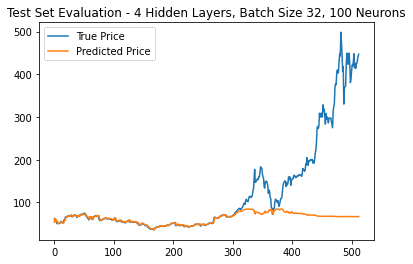

In [98]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig1, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - 4 Hidden Layers, Batch Size 32, 100 Neurons")

In [100]:
# Build Model 2: 4 hidden layers, 100 neurons, batch size 785, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model2 = Sequential()

model2.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(.2))
model2.add(LSTM(units = 100, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(units = 100, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(LSTM(units = 100))
model2.add(Dropout(0.2))
model2.add(Dense(units = 1))
model2.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history2 = model2.fit(X_train, y_train, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train2 = model2.predict(X_train)
preds_test2 = model2.predict(X_test)

# Unscale 
preds_train_orig2 = sc.inverse_transform(preds_train2)
preds_test_orig2 = sc.inverse_transform(preds_test2)
y_train_orig = sc.inverse_transform(y_train.reshape(-1,1))
y_test_orig = sc.inverse_transform(y_test.reshape(-1,1))

In [101]:
model2_begloss = model2.evaluate(X_test[:300,:,:], y_test[:300])
model2_endloss = model2.evaluate(X_test[300:,:,:], y_test[300:])
model2_loss = model2.evaluate(X_test, y_test)

print("Model 2 Beginning Loss: {}".format(model2_begloss))
print("Model 2 Ending Loss: {}".format(model2_endloss))
print("Model 2 Overall Loss: {}".format(model2_loss))

17/17 [==============================] - 0s 3ms/step - loss: 0.3312
Model 2 Beginning Loss: 0.011447218246757984
Model 2 Ending Loss: 0.7815234661102295
Model 2 Overall Loss: 0.3311864733695984


Text(0.5, 1.0, 'Test Set Evaluation - 4 Hidden Layers, Batch Size 785, 100 Neurons')

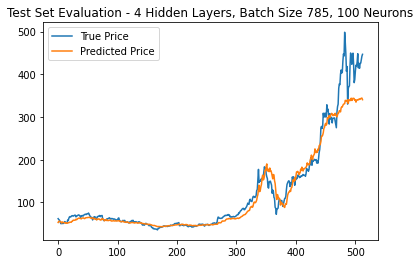

In [102]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig2, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - 4 Hidden Layers, Batch Size 785, 100 Neurons")

In [103]:
# Build Model 3: 2 hidden layers, 100 neurons, batch size 785, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model3 = Sequential()

model3.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model3.add(Dropout(.2))
model3.add(LSTM(units = 100))
model3.add(Dropout(0.2))
model3.add(Dense(units = 1))
model3.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history3 = model3.fit(X_train, y_train, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train3 = model3.predict(X_train)
preds_test3 = model3.predict(X_test)

# Unscale 
preds_train_orig3 = sc.inverse_transform(preds_train3)
preds_test_orig3 = sc.inverse_transform(preds_test3)
y_train_orig = sc.inverse_transform(y_train.reshape(-1,1))
y_test_orig = sc.inverse_transform(y_test.reshape(-1,1))

In [104]:
model3_begloss = model3.evaluate(X_test[:300,:,:], y_test[:300])
model3_endloss = model3.evaluate(X_test[300:,:,:], y_test[300:])
model3_loss = model3.evaluate(X_test, y_test)

print("Model 3 Beginning Loss: {}".format(model3_begloss))
print("Model 3 Ending Loss: {}".format(model3_endloss))
print("Model 3 Overall Loss: {}".format(model3_loss))


17/17 [==============================] - 0s 2ms/step - loss: 0.1880
Model 3 Beginning Loss: 0.0058127655647695065
Model 3 Ending Loss: 0.44463059306144714
Model 3 Overall Loss: 0.1880119889974594


Text(0.5, 1.0, 'Test Set Evaluation - 2 Hidden Layers, Batch Size 785, 100 Neurons')

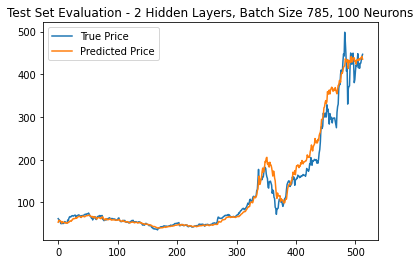

In [105]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig3, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - 2 Hidden Layers, Batch Size 785, 100 Neurons")

In [106]:
# Build Model 4: 2 hidden layers, 32 neurons, batch size 785, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

model4 = Sequential()

model4.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model4.add(Dropout(.2))
model4.add(LSTM(units = 32))
model4.add(Dropout(0.2))
model4.add(Dense(units = 1))
model4.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history4 = model4.fit(X_train, y_train, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train4 = model4.predict(X_train)
preds_test4 = model4.predict(X_test)

# Unscale 
preds_train_orig4 = sc.inverse_transform(preds_train4)
preds_test_orig4 = sc.inverse_transform(preds_test4)
y_train_orig = sc.inverse_transform(y_train.reshape(-1,1))
y_test_orig = sc.inverse_transform(y_test.reshape(-1,1))

In [107]:
model4_begloss = model4.evaluate(X_test[:300,:,:], y_test[:300])
model4_endloss = model4.evaluate(X_test[300:,:,:], y_test[300:])
model4_loss = model4.evaluate(X_test, y_test)

print("Model 4 Beginning Loss: {}".format(model4_begloss))
print("Model 4 Ending Loss: {}".format(model4_endloss))
print("Model 4 Overall Loss: {}".format(model4_loss))

17/17 [==============================] - 0s 2ms/step - loss: 2.6287
Model 4 Beginning Loss: 0.010990720242261887
Model 4 Ending Loss: 6.315509796142578
Model 4 Overall Loss: 2.6286566257476807


Text(0.5, 1.0, 'Test Set Evaluation - 2 Hidden Layers, Batch Size 785, 32 Neurons')

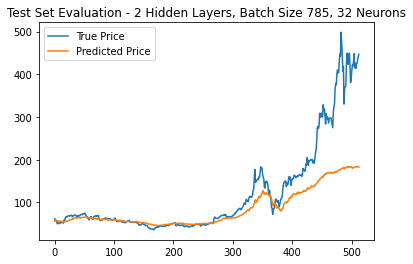

In [108]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig4, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - 2 Hidden Layers, Batch Size 785, 32 Neurons")

Text(0.5, 1.0, 'Test Set Evaluation - Models 1-4')

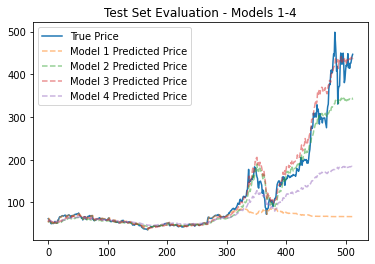

In [110]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig1, '--', label="Model 1 Predicted Price", alpha=.5)
plt.plot(preds_test_orig2, '--', label="Model 2 Predicted Price", alpha=.5)
plt.plot(preds_test_orig3, '--', label="Model 3 Predicted Price", alpha=.5)
plt.plot(preds_test_orig4, '--', label="Model 4 Predicted Price", alpha=.5)
plt.legend()
plt.title("Test Set Evaluation - Models 1-4")

# Alternative Models

In the previous section, we used a model with 3 lags 1, 7, and 14 days. The analogy to traditional time series representation would be $x_t = f(x_{t-1}, x_{t-7},x_{t-14})$. 

In this section, we construct simpler LSTM models with the above lags but individually, i.e. there is a lag 1 model, a lag 7 model, and a lag 14 model. Note that we'll still specify a look_back window of size 14 so we can make easy comparisons to the above models. 

Model 5: $x_t = f(x_{t-1})$

Model 6: $x_t = f(x_{t-7})$

Model 7: $x_t = f(x_{t-14})$

In [56]:
# Create dataset with lag 1 
X_train_1, y_train_1 = create_dataset(dataset=training_set_scaled, look_back=14, lag_list=[1])
X_test_1, y_test_1 = create_dataset(dataset=testing_set_scaled, look_back=14, lag_list=[1])
print("Lag 1 Dataset")
print("X_train Shape: {}".format(X_train_1.shape))
print("y_train Shape: {}".format(y_train_1.shape))
print("X_test Shape: {}".format(X_test_1.shape))
print("y_test Shape: {}\n".format(y_test_1.shape))

# Create dataset with lag 7
X_train_7, y_train_7 = create_dataset(dataset=training_set_scaled, look_back=14, lag_list=[7])
X_test_7, y_test_7 = create_dataset(dataset=testing_set_scaled, look_back=14, lag_list=[7])
print("Lag 7 Dataset")
print("X_train Shape: {}".format(X_train_7.shape))
print("y_train Shape: {}".format(y_train_7.shape))
print("X_test Shape: {}".format(X_test_7.shape))
print("y_test Shape: {}\n".format(y_test_7.shape))

# Create dataset with lag 14
X_train_14, y_train_14 = create_dataset(dataset=training_set_scaled, look_back=14, lag_list=[14])
X_test_14, y_test_14 = create_dataset(dataset=testing_set_scaled, look_back=14, lag_list=[14])
print("Lag 14 Dataset")
print("X_train Shape: {}".format(X_train_14.shape))
print("y_train Shape: {}".format(y_train_14.shape))
print("X_test Shape: {}".format(X_test_14.shape))
print("y_test Shape: {}\n".format(y_test_14.shape))

Lag 1 Dataset
X_train Shape: (785, 1, 1)
y_train Shape: (785,)
X_test Shape: (513, 1, 1)
y_test Shape: (513,)

Lag 7 Dataset
X_train Shape: (785, 1, 1)
y_train Shape: (785,)
X_test Shape: (513, 1, 1)
y_test Shape: (513,)

Lag 14 Dataset
X_train Shape: (785, 1, 1)
y_train Shape: (785,)
X_test Shape: (513, 1, 1)
y_test Shape: (513,)



In [123]:
# Build Model 5 - Lag 1, 2 Hidden Layers, 100 Neurons, Batch Size 785, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model5 = Sequential()

model5.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_1.shape[1], X_train_1.shape[2])))
model5.add(Dropout(.2))
model5.add(LSTM(units = 100))
model5.add(Dropout(0.2))
model5.add(Dense(units = 1))
model5.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history5 = model5.fit(X_train_1, y_train_1, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train5 = model5.predict(X_train_1)
preds_test5 = model5.predict(X_test_1)

# Unscale 
preds_train_orig5 = sc.inverse_transform(preds_train5)
preds_test_orig5 = sc.inverse_transform(preds_test5)
y_train_orig5 = sc.inverse_transform(y_train_1.reshape(-1,1))
y_test_orig5 = sc.inverse_transform(y_test_1.reshape(-1,1))

In [124]:
model5_begloss = model5.evaluate(X_test_1[:300,:,:], y_test_1[:300])
model5_endloss = model5.evaluate(X_test_1[300:,:,:], y_test_1[300:])
model5_loss = model5.evaluate(X_test_1, y_test_1)

print("Model 5 Beginning Loss: {}".format(model5_begloss))
print("Model 5 Ending Loss: {}".format(model5_endloss))
print("Model 5 Overall Loss: {}".format(model5_loss))

17/17 [==============================] - 0s 2ms/step - loss: 0.1661
Model 5 Beginning Loss: 0.0031508083920925856
Model 5 Ending Loss: 0.3956184983253479
Model 5 Overall Loss: 0.1661052256822586


Text(0.5, 1.0, 'Test Set Evaluation - Lag 1, 2 Hidden Layers, Batch Size 785, 100 Neurons')

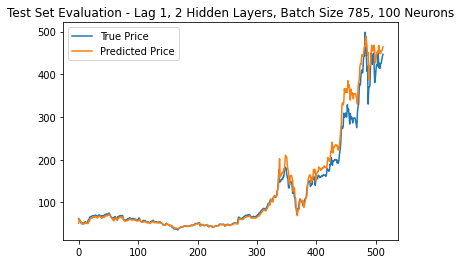

In [125]:
plt.plot(y_test_orig5, label="True Price")
plt.plot(preds_test_orig5, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - Lag 1, 2 Hidden Layers, Batch Size 785, 100 Neurons")

In [126]:
# Build Model 6 - Lag 7, 2 Hidden Layers, 100 Neurons, Batch Size 785, dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model6 = Sequential()

model6.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_7.shape[1], X_train_7.shape[2])))
model6.add(Dropout(.2))
model6.add(LSTM(units = 100))
model6.add(Dropout(0.2))
model6.add(Dense(units = 1))
model6.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history6 = model6.fit(X_train_7, y_train_7, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train6 = model6.predict(X_train_7)
preds_test6 = model6.predict(X_test_7)

# Unscale 
preds_train_orig6 = sc.inverse_transform(preds_train6)
preds_test_orig6 = sc.inverse_transform(preds_test6)
y_train_orig6 = sc.inverse_transform(y_train_7.reshape(-1,1))
y_test_orig6 = sc.inverse_transform(y_test_7.reshape(-1,1))

In [127]:
model6_begloss = model6.evaluate(X_test_7[:300,:,:], y_test_7[:300])
model6_endloss = model6.evaluate(X_test_7[300:,:,:], y_test_7[300:])
model6_loss = model6.evaluate(X_test_7, y_test_7)

print("Model 6 Beginning Loss: {}".format(model6_begloss))
print("Model 6 Ending Loss: {}".format(model6_endloss))
print("Model 6 Overall Loss: {}".format(model6_loss))

17/17 [==============================] - 0s 2ms/step - loss: 0.9562
Model 6 Beginning Loss: 0.013416292145848274
Model 6 Ending Loss: 2.283982515335083
Model 6 Overall Loss: 0.9561660289764404


Text(0.5, 1.0, 'Test Set Evaluation - Lag 7, 2 Hidden Layers, Batch Size 785, 100 Neurons')

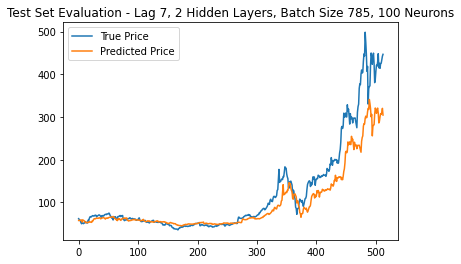

In [128]:
plt.plot(y_test_orig6, label="True Price")
plt.plot(preds_test_orig6, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - Lag 7, 2 Hidden Layers, Batch Size 785, 100 Neurons")

In [129]:
# Build Model 7 - Lag 14, 2 Hidden Layers, 100 Neurons, Batch Size 785, Dropout .2
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model7 = Sequential()

model7.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_14.shape[1], X_train_14.shape[2])))
model7.add(Dropout(.2))
model7.add(LSTM(units = 50))
model7.add(Dropout(0.2))
model7.add(Dense(units = 1))
model7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history7 = model7.fit(X_train_14, y_train_14, epochs = 100, batch_size = 785, callbacks=[callback], verbose=0)

# Make predictions 
preds_train7 = model7.predict(X_train_14)
preds_test7 = model7.predict(X_test_14)

# Unscale 
preds_train_orig7 = sc.inverse_transform(preds_train7)
preds_test_orig7 = sc.inverse_transform(preds_test7)
y_train_orig7 = sc.inverse_transform(y_train_14.reshape(-1,1))
y_test_orig7 = sc.inverse_transform(y_test_14.reshape(-1,1))

In [130]:
model7_begloss = model7.evaluate(X_test_14[:300,:,:], y_test_14[:300])
model7_endloss = model7.evaluate(X_test_14[300:,:,:], y_test_14[300:])
model7_loss = model7.evaluate(X_test_14, y_test_14)

print("Model 7 Beginning Loss: {}".format(model7_begloss))
print("Model 7 Ending Loss: {}".format(model7_endloss))
print("Model 7 Overall Loss: {}".format(model7_loss))

17/17 [==============================] - 0s 2ms/step - loss: 2.6327
Model 7 Beginning Loss: 0.0216202512383461
Model 7 Ending Loss: 6.310190200805664
Model 7 Overall Loss: 2.6326639652252197


Text(0.5, 1.0, 'Test Set Evaluation - Lag 14, 2 Hidden Layers, Batch Size 785, 100 Neurons')

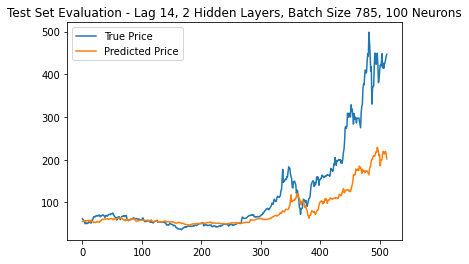

In [131]:
plt.plot(y_test_orig7, label="True Price")
plt.plot(preds_test_orig7, label="Predicted Price")
plt.legend()
plt.title("Test Set Evaluation - Lag 14, 2 Hidden Layers, Batch Size 785, 100 Neurons")

Text(0.5, 1.0, 'Test Set Evaluation - Models 3, 5,6 7')

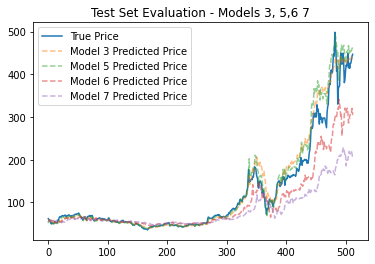

In [132]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig3, '--', label="Model 3 Predicted Price", alpha=.5)
plt.plot(preds_test_orig5, '--', label="Model 5 Predicted Price", alpha=.5)
plt.plot(preds_test_orig6, '--', label="Model 6 Predicted Price", alpha=.5)
plt.plot(preds_test_orig7, '--', label="Model 7 Predicted Price", alpha=.5)
plt.legend()
plt.title("Test Set Evaluation - Models 3, 5,6 7")

Text(0.5, 1.0, 'Test Set Evaluation - All Models')

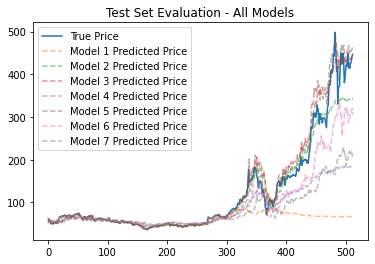

In [133]:
plt.plot(y_test_orig, label="True Price")
plt.plot(preds_test_orig1, '--', label="Model 1 Predicted Price", alpha=.5)
plt.plot(preds_test_orig2, '--', label="Model 2 Predicted Price", alpha=.5)
plt.plot(preds_test_orig3, '--', label="Model 3 Predicted Price", alpha=.5)
plt.plot(preds_test_orig4, '--', label="Model 4 Predicted Price", alpha=.5)
plt.plot(preds_test_orig5, '--', label="Model 5 Predicted Price", alpha=.5)
plt.plot(preds_test_orig6, '--', label="Model 6 Predicted Price", alpha=.5)
plt.plot(preds_test_orig7, '--', label="Model 7 Predicted Price", alpha=.5)
plt.legend()
plt.title("Test Set Evaluation - All Models")

In [136]:
model1loss_arr = np.array([model1_begloss, model1_endloss, model1_loss]).reshape(1,3)
model2loss_arr = np.array([model2_begloss, model2_endloss, model2_loss]).reshape(1,3)
model3loss_arr = np.array([model3_begloss, model3_endloss, model3_loss]).reshape(1,3)
model4loss_arr = np.array([model4_begloss, model4_endloss, model4_loss]).reshape(1,3)
model5loss_arr = np.array([model5_begloss, model5_endloss, model5_loss]).reshape(1,3)
model6loss_arr = np.array([model6_begloss, model6_endloss, model6_loss]).reshape(1,3)
model7loss_arr = np.array([model7_begloss, model7_endloss, model7_loss]).reshape(1,3)
c_loss_arr = np.vstack((model1loss_arr, model2loss_arr, model3loss_arr, model4loss_arr, model5loss_arr, model6loss_arr, model7loss_arr))
c_loss_df = pd.DataFrame(c_loss_arr)
c_loss_df.columns = ["Beginning Loss", "Ending Loss", "Overall Loss"]
c_loss_df.index = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", "Model 7"]
c_loss_df

,Beginning Loss,Ending Loss,Overall Loss
Model 1,0.001645,15.059100,6.253570
Model 2,0.011447,0.781523,0.331186
Model 3,0.005813,0.444631,0.188012
Model 4,0.010991,6.315510,2.628657
Model 5,0.003151,0.395618,0.166105
Model 6,0.013416,2.283983,0.956166
Model 7,0.021620,6.310190,2.632664
